In [1]:
import pandas as pd
import numpy as np
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import math


# 1) Development Data

In [2]:
# The Aid data can be downloaded directly here:
!curl -o recipients.csv https://data.un.org/_Docs/SYB/CSV/SYB62_226_201907_Net%20Disbursements%20from%20Official%20ODA%20to%20Recipients.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1345k  100 1345k    0     0   264k      0  0:00:05  0:00:05 --:--:--  302k


In [169]:
recipients_aid_df = pd.read_csv('recipients.csv',engine='python',header = 1)
recipients_aid_df

,Region/Country/Area,Unnamed: 1,Year,Series,Value,Footnotes,Source
0,1,"Total, all countries or areas",1975,Net official development assistance received: ...,15188.71,Including regional aid disbursements in additi...,Organisation for Economic Co-operation and Dev...
1,1,"Total, all countries or areas",1985,Net official development assistance received: ...,26347.81,Including regional aid disbursements in additi...,Organisation for Economic Co-operation and Dev...
2,1,"Total, all countries or areas",1995,Net official development assistance received: ...,48267.84,Including regional aid disbursements in additi...,Organisation for Economic Co-operation and Dev...
3,1,"Total, all countries or areas",2005,Net official development assistance received: ...,82922.81,Including regional aid disbursements in additi...,Organisation for Economic Co-operation and Dev...
4,1,"Total, all countries or areas",2010,Net official development assistance received: ...,94440.61,Including regional aid disbursements in additi...,Organisation for Economic Co-operation and Dev...
...,...,...,...,...,...,...,...
5026,716,Zimbabwe,2005,Net official development assistance received: ...,6.80,NaN,Organisation for Economic Co-operation and Dev...
5027,716,Zimbabwe,2010,Net official development assistance received: ...,8.18,NaN,Organisation for Economic Co-operation and Dev...
5028,716,Zimbabwe,2015,Net official development assistance received: ...,5.50,NaN,Organisation for Economic Co-operation and Dev...
5029,716,Zimbabwe,2016,Net official development assistance received: ...,4.41,NaN,Organisation for Economic Co-operation and Dev...


In [4]:
# Dictionary containing regions and the countries in those regions (only includes countries in this data set)
region_dict = {'Southern Africa':['Angola','Botswana','Burundi','Cabo Verde','Cameroon','Central African Republic','Comoros',
                         'Congo','Dem. Rep. of the Congo','Equatorial Guinea','Eswatini','Ethiopia','Kenya', 'Kiribati',
                         'Lesotho','Liberia','Madagascar', 'Malawi','Mozambique','Namibia','Rwanda','Saint Helena',
                         'Sao Tome and Principe','Seychelles', 'Solomon Islands','South Africa','Uganda',
                         'United Rep. of Tanzania','Zambia', 'Zimbabwe'],
               'Northern Africa':['Algeria','Djibouti','Egypt','Eritrea','Libya','Morocco','Somalia','Sudan','Tunisia',],
               'Sub-Saharan Africa':['Benin','Burkina Faso','Chad','C�te d�Ivoire','Gabon', 'Gambia','Ghana','Guinea',
                                     'Guinea-Bissau','Mali','Mauritania', 'Mauritius','Niger', 'Nigeria','Senegal',
                                     'Sierra Leone','South Sudan','Togo'],
               'Americas':['Anguilla','Antigua and Barbuda','Aruba','Bahamas','Barbados','Belize','Bermuda',
                           'British Virgin Islands','Cayman Islands','Costa Rica','Cuba','Dominica','Dominican Republic',
                           'El Salvador','Grenada','Guatemala','Haiti', 'Honduras','Jamaica','Nicaragua','Panama',
                           'Saint Kitts and Nevis','Saint Lucia','Saint Vincent & Grenadines','Trinidad and Tobago',
                           'Turks and Caicos Islands'], 
               'North America':['Mexico'], 
               'South America':['Argentina','Brazil','Bolivia (Plurin. State of)','Botswana','Chile','Colombia',
                                'Ecuador','Guyana','Paraguay', 'Peru','Suriname','Uruguay','Venezuela (Boliv. Rep. of)'],
               'Asia':['China','China, Hong Kong SAR','China, Macao SAR',"Dem. People's Rep. Korea",'Mongolia',
                       'Republic of Korea'], 
               'Eastern and South-Eastern Asia':['Brunei Darussalam','Cambodia','Indonesia',"Lao People's Dem. Rep.",
                                                 'Malaysia','Myanmar','Philippines','Sierra Leone','Thailand',
                                                 'Viet Nam'], 
               'South-central Asia':['Afghanistan','Azerbaijan','Bangladesh','Bhutan','India','Kazakhstan','Kyrgyzstan',
                                     'Maldives','Mayotte','Nepal','Pakistan','Sri Lanka','Tajikistan','Turkmenistan',
                                     'Uzbekistan'],
               'Western Asia':['Bahrain','Georgia','Iran (Islamic Republic of)','Iraq', 'Israel', 'Jordan','Kuwait',
                               'Lebanon','Oman','Qatar','Saudi Arabia','State of Palestine','Syrian Arab Republic',
                               'Turkey','United Arab Emirates','Yemen'], 
               'Europe':['Albania','Armenia','Belarus','Bosnia and Herzegovina','Croatia','Cyprus','Gibraltar','Kosovo',
                         'Malta','Montenegro','Netherlands Antilles [former]','North Macedonia','Republic of Moldova','Serbia','Slovenia','Ukraine'], 
               'Oceania':['Micronesia','Cook Islands','Fiji','French Polynesia','Marshall Islands',
                          'Micronesia (Fed. States of)','Montserrat','Nauru','New Caledonia','Niue',
                          'Northern Mariana Islands','Palau','Papua New Guinea','Samoa','Timor-Leste','Tokelau', 
                          'Tonga','Tuvalu','Vanuatu','Wallis and Futuna Islands']}




In [5]:
def add_region (country,region_dict = region_dict):
    '''Adds a region to country based on a dictionary with the regions as keys and countries in those regions 
    as a value'''
    for k,v in region_dict.items():
        if country in v:
            return k
    return None


In [6]:
def series_to_col (df):
    '''This fucntion takes a dataframe and returns a new data frame with the series and values columns combined such
    that each type of series is a unique column with the coresponding value as its values.'''
    df_r = df.copy()
    df_r = df_r.drop(['Series','Value'], axis = 1)
    df_r.drop_duplicates(subset = ['Country','Year'], keep = 'first', inplace = True)

    df_m = df.copy()
    df_m = df_m.pivot_table(values='Value', index= [df_m.Year,df_m.Country], columns='Series', aggfunc='first')
    df_m.reset_index(inplace = True)
    
    result = pd.merge(df_m, df_r, on=['Country','Year'])
    result = result.fillna(0)
    
    return result


In [7]:
def preprocess_recipients (df,regions_dict,code_dict_path ='UN_Country_Codes.csv' ):
    '''Performs the needed preprocessing steps on the above recipients dataframe'''
    #drop unecesary columns
    df = df.drop(['Source','Footnotes'], axis=1)

    #Rename misnamed columns
    df = df.rename(columns={'Unnamed: 1': "Country", "Region/Country/Area": "Region_Code"})
    df.head(30)

    #Extract measurement type from Series
    df['Type'] = df['Series'].apply(lambda x: re.findall('\((.*?)\)', x)[0])

    #Extract Meaningfull information from series (method of distribution or type of total)
    df['Series'] = df['Series'].apply(lambda x: re.findall('\:(.*?)\(', x)[0])
    df['Series'] = df['Series'].str.strip()
    df.loc[df['Type'] == 'as % GNI', 'Series'] = 'Total(%_GNI)'
    
    # Get rid of global totals and unspecified areas
    df = df[df.Country != 'Total, all countries or areas']
    df = df[ ~ df.Country.str.contains('Areas not specified')]
    
    # Add a region to the country
    df['Region'] = df.Country.apply(lambda c: add_region(c))
    df = df.dropna(subset = ['Region'])
    
    #Read in country codes and add correct country names to growth_ranknings
    country_codes = pd.read_csv(code_dict_path) 
    code_dict = dict(zip(country_codes.Numeric, country_codes.Country))
    df['Country'] = df['Region_Code'].map(code_dict)
    
    # Final clean
    df = df.drop(['Type'], axis =1)
    df = df.dropna()
    df.reset_index(inplace = True, drop = True)
    
    df = series_to_col(df)
    
    return df


In [8]:
df_rec_clean = preprocess_recipients(recipients_aid_df,region_dict)
df_rec_clean

,Year,Country,Bilateral,Multilateral,Total,Total(%_GNI),Region_Code,Region
0,1975,Afghanistan,38.39,28.59,66.98,2.77,4,South-central Asia
1,1975,Algeria,212.70,22.57,235.27,1.53,12,Northern Africa
2,1975,Angola,4.15,0.61,4.76,0.00,24,Southern Africa
3,1975,Anguilla,1.66,0.01,1.67,0.00,660,Americas
4,1975,Antigua and Barbuda,1.54,0.52,2.06,0.00,28,Americas
...,...,...,...,...,...,...,...,...
1198,2017,Viet Nam,1738.35,653.83,2392.18,1.12,704,Eastern and South-Eastern Asia
1199,2017,Wallis and Futuna,88.88,0.64,89.52,0.00,876,Oceania
1200,2017,Yemen,2698.47,535.54,3234.01,0.00,887,Western Asia
1201,2017,Zambia,766.66,269.55,1036.21,4.14,894,Southern Africa


In [167]:
len(df_rec_clean.Region.unique())

12

In [9]:
df_rec_clean.isna().sum()

Year            0
Country         0
Bilateral       0
Multilateral    0
Total           0
Total(%_GNI)    0
Region_Code     0
Region          0
dtype: int64

# 2) Growth Data

In [184]:
# Read in the growth data
growth_rankings_df = pd.read_csv('rankings.csv',engine='python')
growth_rankings_df

,Unnamed: 0,location_id,year,sitc_eci,hs_eci,growth_proj,sitc_eci_rank,hs_eci_rank,code
0,1,2,1995,-2.001223,-2.148367,NaN,127.0,217.0,AGO
1,2,2,1996,-2.120867,-2.144461,NaN,129.0,215.0,AGO
2,3,2,1997,-1.800330,-1.424870,NaN,127.0,204.0,AGO
3,4,2,1998,-1.756738,-1.650229,NaN,127.0,206.0,AGO
4,5,2,1999,-1.703370,-1.384564,NaN,124.0,202.0,AGO
...,...,...,...,...,...,...,...,...,...
3054,3055,248,2013,-0.672232,-0.781233,5.08,97.0,184.0,ZWE
3055,3056,248,2014,-0.696330,-0.807621,4.93,100.0,187.0,ZWE
3056,3057,248,2015,-0.874097,-0.930933,4.73,108.0,194.0,ZWE
3057,3058,248,2016,-0.971397,-1.149360,4.71,109.0,208.0,ZWE


In [190]:
def clean_growth (df,code_dict_path ='UN_Country_Codes.csv'):
    '''This function performs the needed cleaning and preprocessing on the economic complexity data set.'''
    
    # Drop Uneeded columns
    df = df.drop(['hs_eci', 'hs_eci_rank','Unnamed: 0','growth_proj','sitc_eci_rank'], axis=1)
    
    # Convert country names to the correct spelling and syntax (as determined by the un ocuntry codes csv)
    country_codes = pd.read_csv(code_dict_path)
    code_dict = dict(zip(country_codes.Code, country_codes.Country))
    df['country'] = df['code'].map(code_dict)
    
    df = df.dropna()
    
    return df

In [191]:
clean_growth_df = clean_growth(growth_rankings_df)

In [192]:
clean_growth_df

,location_id,year,sitc_eci,code,country
0,2,1995,-2.001223,AGO,Angola
1,2,1996,-2.120867,AGO,Angola
2,2,1997,-1.800330,AGO,Angola
3,2,1998,-1.756738,AGO,Angola
4,2,1999,-1.703370,AGO,Angola
...,...,...,...,...,...
3054,248,2013,-0.672232,ZWE,Zimbabwe
3055,248,2014,-0.696330,ZWE,Zimbabwe
3056,248,2015,-0.874097,ZWE,Zimbabwe
3057,248,2016,-0.971397,ZWE,Zimbabwe


In [193]:
clean_growth_df.sitc_eci.max()

2.8253192901611297

In [194]:
clean_growth_df.isna().sum()

location_id    0
year           0
sitc_eci       0
code           0
country        0
dtype: int64

In [197]:
len(clean_growth_df.country.unique())

133

# 3) Merge the Data Sets

In [84]:
growth_countries = set(clean_growth_df['country'].unique())
aid_countries = set(df_rec_clean['Country'].unique())

allCountries = list(growth_countries.intersection(aid_countries))
print(len(allCountries))

101


In [85]:
#limit each dataframe down to the intersection of countries (only countries included in both data sets)
growth_rankings_df_Subset = clean_growth_df.copy()
recipients_aid_df_Subset = df_rec_clean.copy()

growth_rankings_df_Subset = growth_rankings_df_Subset[growth_rankings_df_Subset['country'].isin(allCountries)]
recipients_aid_df_Subset = recipients_aid_df_Subset[recipients_aid_df_Subset['Country'].isin(allCountries)]


In [86]:
#merge the two databases on country and year
final_df = recipients_aid_df_Subset.merge(growth_rankings_df_Subset, how='inner', 
                                          left_on=["Country", "Year"], right_on=["country","year"])

#get rid of overlapping columns
final_df = final_df.drop(['year','location_id','country'],axis = 1)

# Select needed cols with outcome col last
final_df = final_df[['Country','Region','Year', 'Bilateral', 'Multilateral', 'Total(%_GNI)', 'Total', 'sitc_eci']]



In [87]:
final_df

,Country,Region,Year,Bilateral,Multilateral,Total(%_GNI),Total,sitc_eci
0,Albania,Europe,1995,117.59,63.01,7.32,180.60,-0.560130
1,Algeria,Northern Africa,1995,271.70,24.04,0.75,295.74,-0.700374
2,Angola,Southern Africa,1995,303.65,112.77,8.73,416.42,-2.001223
3,Argentina,South America,1995,131.32,16.86,0.06,148.18,0.189551
4,Armenia,Europe,1995,0.00,106.81,14.85,217.71,0.057307
...,...,...,...,...,...,...,...,...
540,Venezuela (Bolivarian Republic of),South America,2017,72.48,14.06,0.00,86.54,-1.225530
541,Viet Nam,Eastern and South-Eastern Asia,2017,1738.35,653.83,1.12,2392.18,0.093079
542,Yemen,Western Asia,2017,2698.47,535.54,0.00,3234.01,-1.188026
543,Zambia,Southern Africa,2017,766.66,269.55,4.14,1036.21,-1.073317


# 4) Graph Data

### Relevant graphs to explore the composition of the final data frame cleaned and created above

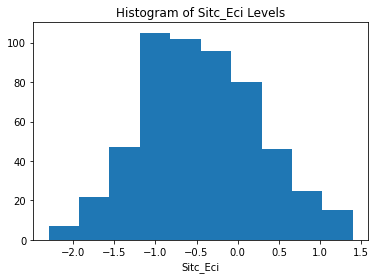

In [88]:
plt.hist(final_df.sitc_eci)
plt.title('Histogram of Sitc_Eci Levels')
plt.xlabel('Sitc_Eci')
plt.show()

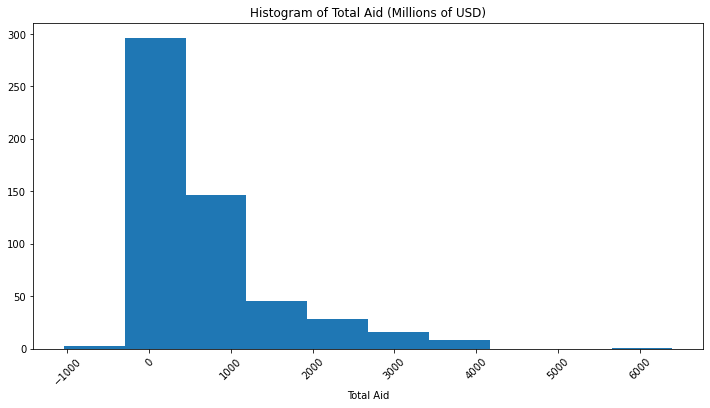

In [89]:
plt.figure(figsize = (12,6))
plt.hist(final_df.Total)
plt.xticks(rotation=45)
plt.title('Histogram of Total Aid (Millions of USD)')
plt.xlabel('Total Aid')
plt.show()

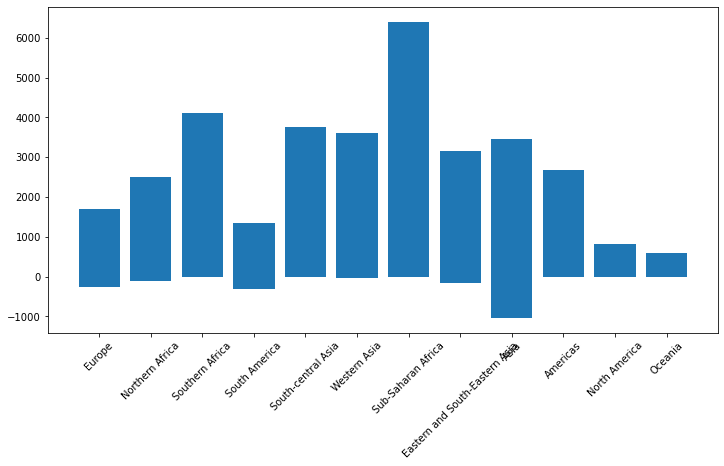

In [90]:
plt.figure(figsize = (12,6))
plt.bar(final_df.Region, final_df.Total)
plt.xticks(rotation=45)
plt.show()

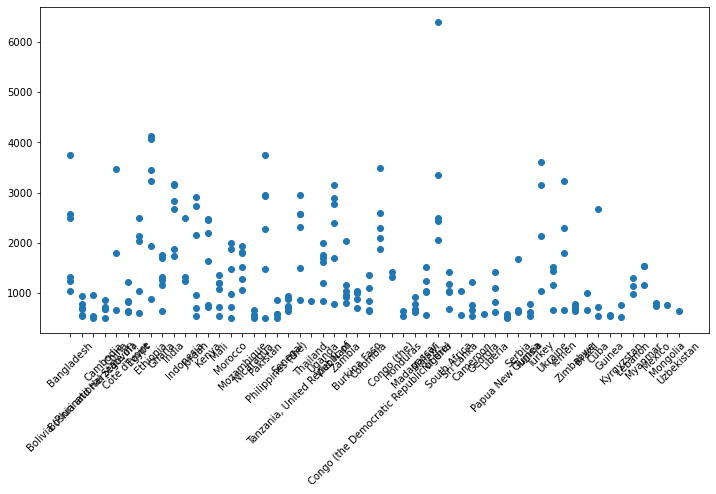

In [91]:
plt.figure(figsize = (12,6))
plt.scatter(final_df.Country[final_df.Total > 500], final_df.Total[final_df.Total > 500])
plt.xticks(rotation=45)
plt.show()

# 5) Feature Preprocessing and Extraction

### 5.1) Use min max scaler on continous variables and encode categorical variables

In [92]:
from sklearn.preprocessing import MinMaxScaler

In [93]:
scaler = MinMaxScaler()

In [94]:
scaled_data = scaler.fit_transform(final_df.iloc[:,2:-1])

In [95]:
scaled_data = pd.DataFrame(scaled_data, columns = final_df.columns[2:-1])

In [96]:
reg_dummies = pd.get_dummies(final_df['Region'], prefix='Region')

In [97]:
scaled_data = scaled_data.set_index(reg_dummies.index)

In [98]:
result_new = reg_dummies.join([scaled_data, final_df.iloc[:,-1:]])


In [99]:
result_new

,Region_Americas,Region_Asia,Region_Eastern and South-Eastern Asia,Region_Europe,Region_North America,Region_Northern Africa,Region_Oceania,Region_South America,Region_South-central Asia,Region_Southern Africa,Region_Sub-Saharan Africa,Region_Western Asia,Year,Bilateral,Multilateral,Total(%_GNI),Total,sitc_eci
0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.095590,0.024473,0.061076,0.164585,-0.560130
1,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.119472,0.009402,0.009631,0.180047,-0.700374
2,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.124423,0.043717,0.072117,0.196253,-2.001223
3,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.097718,0.006625,0.004228,0.160232,0.189551
4,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.077368,0.041412,0.120038,0.169569,0.057307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,0,0,0,0,0,0,0,1,0,0,0,0,1.0,0.088600,0.005542,0.003759,0.151955,-1.225530
541,0,0,1,0,0,0,0,0,0,0,0,0,1.0,0.346751,0.252966,0.012528,0.461568,0.093079
542,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0.495536,0.207219,0.003759,0.574614,-1.188026
543,0,0,0,0,0,0,0,0,0,1,0,0,1.0,0.196173,0.104350,0.036176,0.279481,-1.073317


### 5.2) Create a correlation matrix to check for multi-colinearity

In [101]:
corr = result_new.iloc[:,:-1].corr()
corr


,Region_Americas,Region_Asia,Region_Eastern and South-Eastern Asia,Region_Europe,Region_North America,Region_Northern Africa,Region_Oceania,Region_South America,Region_South-central Asia,Region_Southern Africa,Region_Sub-Saharan Africa,Region_Western Asia,Year,Bilateral,Multilateral,Total(%_GNI),Total
Region_Americas,1.000000,-0.053425,-0.106211,-0.106211,-0.036059,-0.082487,-0.036059,-0.120208,-0.120208,-0.166954,-0.126862,-0.103766,-0.007670,-0.127943,-0.181738,-0.097153,-0.162387
Region_Asia,-0.053425,1.000000,-0.048580,-0.048580,-0.016493,-0.037729,-0.016493,-0.054982,-0.054982,-0.076363,-0.058026,-0.047462,-0.019450,-0.082506,-0.017516,-0.023682,-0.043104
Region_Eastern and South-Eastern Asia,-0.106211,-0.048580,1.000000,-0.096579,-0.032789,-0.075007,-0.032789,-0.109307,-0.109307,-0.151814,-0.115358,-0.094356,0.006316,0.039956,-0.038925,-0.068331,0.010898
Region_Europe,-0.106211,-0.048580,-0.096579,1.000000,-0.032789,-0.075007,-0.032789,-0.109307,-0.109307,-0.151814,-0.115358,-0.094356,0.018776,-0.125182,-0.075505,-0.018036,-0.112432
Region_North America,-0.036059,-0.016493,-0.032789,-0.032789,1.000000,-0.025465,-0.011132,-0.037110,-0.037110,-0.051541,-0.039164,-0.032034,0.002144,-0.003526,-0.052041,-0.048440,-0.023392
Region_Northern Africa,-0.082487,-0.037729,-0.075007,-0.075007,-0.025465,1.000000,-0.025465,-0.084891,-0.084891,-0.117903,-0.089590,-0.073280,0.004905,0.014684,-0.015667,-0.089047,0.002711
Region_Oceania,-0.036059,-0.016493,-0.032789,-0.032789,-0.011132,-0.025465,1.000000,-0.037110,-0.037110,-0.051541,-0.039164,-0.032034,0.002144,-0.009416,-0.049406,0.002800,-0.026483
Region_South America,-0.120208,-0.054982,-0.109307,-0.109307,-0.037110,-0.084891,-0.037110,1.000000,-0.123711,-0.171820,-0.130560,-0.106791,0.007149,-0.136126,-0.172831,-0.138702,-0.164695
Region_South-central Asia,-0.120208,-0.054982,-0.109307,-0.109307,-0.037110,-0.084891,-0.037110,-0.123711,1.000000,-0.171820,-0.130560,-0.106791,0.007149,0.031722,0.153911,-0.075061,0.082546
Region_Southern Africa,-0.166954,-0.076363,-0.151814,-0.151814,-0.051541,-0.117903,-0.051541,-0.171820,-0.171820,1.000000,-0.181331,-0.148319,0.036193,0.206431,0.215133,0.356401,0.225314


In [102]:
corr_sig = corr[(corr.iloc[:,:] > .8) | (corr.iloc[:,:] < -.8) ]
corr_sig.count()

Region_Americas                          1
Region_Asia                              1
Region_Eastern and South-Eastern Asia    1
Region_Europe                            1
Region_North America                     1
Region_Northern Africa                   1
Region_Oceania                           1
Region_South America                     1
Region_South-central Asia                1
Region_Southern Africa                   1
Region_Sub-Saharan Africa                1
Region_Western Asia                      1
Year                                     1
Bilateral                                2
Multilateral                             2
Total(%_GNI)                             1
Total                                    3
dtype: int64

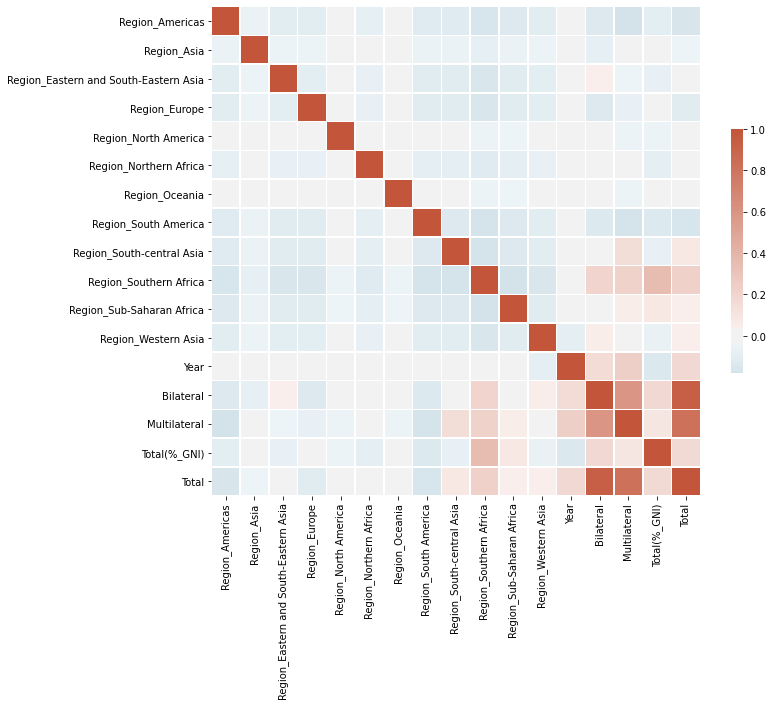

In [103]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### From the Above heat map we can see that there is multicolinearity between total and multilateral and bilateral aid. This makes sense as total is created from the sum of the the two columns and is entirely dependent on them. Remove Total Column.

In [104]:
result_new = result_new.drop(['Total'],axis = 1)

### 5.3) Finally, Select only the most important features using mutual information

In [112]:
from sklearn.feature_selection import mutual_info_regression

In [113]:
x_new = mutual_info_regression(result_new.iloc[:,1:],result_new['sitc_eci'])

In [114]:
n = 4
res = sorted(range(len(x_new)), key = lambda sub: x_new[sub])[-n:] 
res

[2, 12, 14, 15]

In [115]:
for i in res:
    print(f'Mutual Information Gain: {x_new[i]}')
    print(f'Feature Chosen: {result_new.columns[i]}')
    print('\n')

Mutual Information Gain: 0.0839825706806625
Feature Chosen: Region_Eastern and South-Eastern Asia


Mutual Information Gain: 0.11968245361921426
Feature Chosen: Year


Mutual Information Gain: 0.16389974484967462
Feature Chosen: Multilateral


Mutual Information Gain: 5.043750414478881
Feature Chosen: Total(%_GNI)




#### Limit the dataframe to only the most important variables as selected by mutual information gain above

In [116]:
clean_df = result_new[['Bilateral','Year','Multilateral','Total(%_GNI)','sitc_eci']]

In [117]:
clean_df

,Bilateral,Year,Multilateral,Total(%_GNI),sitc_eci
0,0.095590,0.0,0.024473,0.061076,-0.560130
1,0.119472,0.0,0.009402,0.009631,-0.700374
2,0.124423,0.0,0.043717,0.072117,-2.001223
3,0.097718,0.0,0.006625,0.004228,0.189551
4,0.077368,0.0,0.041412,0.120038,0.057307
...,...,...,...,...,...
540,0.088600,1.0,0.005542,0.003759,-1.225530
541,0.346751,1.0,0.252966,0.012528,0.093079
542,0.495536,1.0,0.207219,0.003759,-1.188026
543,0.196173,1.0,0.104350,0.036176,-1.073317



# 6) Model Selection and Initial implementation

### 6.1) Split the data into training and testing

In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(clean_df.iloc[:,:-1],clean_df['sitc_eci'], 
                                                    test_size=0.2, random_state=1)


In [122]:
X_train.shape

(436, 4)

In [123]:
X_test.shape

(109, 4)

### 6.2) Linear Regression

In [124]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [125]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [126]:
# Train MSE
pred = lr.predict(X_train)
mean_squared_error(y_train,pred)

0.4635801996879614

In [127]:
# Test MSE
pred = lr.predict(X_test)
mean_squared_error(y_test,pred)

0.5504940734260749

### 6.3) KNN Regression

In [128]:
from sklearn.neighbors import KNeighborsRegressor

In [129]:
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)

KNeighborsRegressor()

In [130]:
# Train MSE
pred = knn.predict(X_train)
mean_squared_error(y_train,pred)

0.37643036231734245

In [131]:
# Test MSE
pred = knn.predict(X_test)
mean_squared_error(y_test,pred)

0.5783823721073461

### 6.4) Random Forests Regression

In [132]:
from sklearn.ensemble import RandomForestRegressor

In [133]:
forest = RandomForestRegressor()
forest.fit(X_train,y_train)

RandomForestRegressor()

In [134]:
pred = forest.predict(X_train)
mean_squared_error(y_train,pred)

0.04946434184032744

In [135]:
pred = forest.predict(X_test)
mean_squared_error(y_test,pred)

0.41737360220799347

# 7) Model CV Grid Search to Choose Model and Tune Parameters

In [138]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer

# Make an mse scorer for the following grid searches
mse = make_scorer(mean_squared_error, greater_is_better=False)

## 7.1) Linear Regression Grid CV

In [139]:
lr = LinearRegression()
lr.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [140]:
params = {'fit_intercept':[True,False],
         'normalize':[True,False]}
grid_lr = GridSearchCV(lr, params, cv = 10, scoring = mse)

grid_lr.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [141]:
grid_lr.best_params_

{'fit_intercept': True, 'normalize': False}

In [142]:
best_cv_score_lr = abs(grid_lr.best_score_)
best_cv_score_lr

0.49130920558885344

In [143]:
# Training MSE
pred = grid_lr.predict(X_train)
train_lr = mean_squared_error(y_train,pred)
train_lr

0.4635801996879614

In [144]:
# Testing MSE
pred = grid_lr.predict(X_test)
test_lr = mean_squared_error(y_test,pred)
test_lr

0.5504940734260749

## 7.2) KNN Grid Search CV

In [145]:
knn = KNeighborsRegressor()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [146]:
params = {'leaf_size':list(range(1,50)),
         'n_neighbors':[2,3,4,5,6,7,8,9,10],
         'p':[1,2]}
grid_knn = GridSearchCV(knn, params, cv = 10, scoring = mse)

In [147]:
grid_knn.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [148]:
grid_knn.best_params_

{'leaf_size': 1, 'n_neighbors': 9, 'p': 1}

In [149]:
best_cv_score_knn = abs(grid_knn.best_score_)
best_cv_score_knn


0.4975315575779372

In [150]:
# Training MSE
pred = grid_knn.predict(X_train)
train_knn = mean_squared_error(y_train,pred)
train_knn

0.3956613618051197

In [151]:
# Tresting MSE
pred = grid_knn.predict(X_test)
test_knn = mean_squared_error(y_test,pred)
test_knn

0.4823682148455555

## 7.3) Random Forests

In [152]:
forest = RandomForestRegressor()
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [153]:
%%time
params = {'max_depth':[2,3,4,5],
         'n_estimators':[75,100,150,200],
          'min_samples_split': [2,3,4,5,10],
          'max_features': ['auto','sqrt','log2']
         }
grid_forest = GridSearchCV(forest, params, cv = 10, scoring = mse)

grid_forest.fit(X_train,y_train)

CPU times: user 8min 45s, sys: 7.69 s, total: 8min 53s
Wall time: 9min 58s


GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 3, 4, 5, 10],
                         'n_estimators': [75, 100, 150, 200]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [154]:
grid_forest.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 3,
 'n_estimators': 150}

In [155]:
best_cv_score_forest = abs(grid_forest.best_score_)
best_cv_score_forest

0.37482445974348827

In [156]:
# Training MSE
pred = grid_forest.predict(X_train)
train_forest = mean_squared_error(y_train,pred)
train_forest

0.2247189542877344

In [157]:
# Tresting MSE
pred = grid_forest.predict(X_test)
test_forest = mean_squared_error(y_test,pred)
test_forest

0.43884755767359396

# 8) Testing and Evaluation

### 8.1) Visualize the performance of the tuned grid search models created above

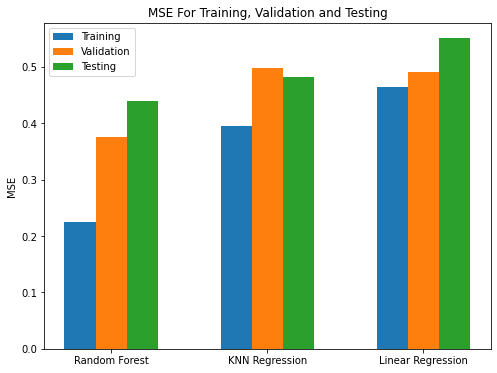

In [160]:
training_mse = [train_forest,train_knn,train_lr]
testing_mse = [test_forest,test_knn,test_lr]
cv_mse = [best_cv_score_forest, best_cv_score_knn, best_cv_score_lr]

labels = ['Random Forest', 'KNN Regression', 'Linear Regression']

x = [i for i in range(len(cv_mse))]

fig, ax = plt.subplots(figsize=(8, 6))

train = ax.bar(np.array(x)-0.2, training_mse, width = 0.2, label = 'Training')
cv = ax.bar(np.array(x), cv_mse, width = 0.2, label = 'Validation')
test = ax.bar(np.array(x)+0.2, testing_mse, width = 0.2,label = 'Testing')
ax.legend()
plt.xticks(range(min(x+x), max(x+x)+1)) 
ax.set_xticklabels(labels)
plt.ylabel('MSE')
plt.title('MSE For Training, Validation and Testing')
plt.show()

#### The above graph tells us that while it is overfit the random forest method is the most accurate and will be chosen as the final model

### 8.2) Evaluate and Visualize the final model

In [162]:
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree
import pydotplus
import io


In [163]:
# View the decision tree for the final random forest model tuned in the gridsearch above
import graphviz


# DOT data
dot_data = tree.export_graphviz(grid_forest.best_estimator_.estimators_[74], out_file=None, 
                                feature_names=clean_df.columns[:-1],  
                                class_names=clean_df.columns[-1],
                                filled=True,
                                rotate =False)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph.view()

'Source.gv.png'

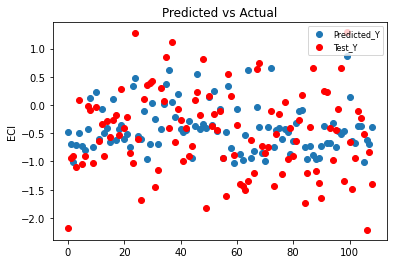

In [164]:
# Visualize the predictions made by the model compared to the actual testing outcome variable
pred = grid_forest.predict(X_test)
predicted = plt.scatter(range(len(pred)),pred)
actual = plt.scatter(range(len(y_test)),y_test, color = 'Red')
plt.legend((predicted,actual),
           ('Predicted_Y', 'Test_Y'),
           scatterpoints=1,
           loc='upper right',
           fontsize=8)
plt.title('Predicted vs Actual')
plt.ylabel('ECI')
plt.show()